# 2. Grouping customers together!

In [341]:
import pandas as pd
import numpy as np
from datetime import datetime
import random
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
from sklearn.cluster import KMeans
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from pathlib import Path

## 2.1 Getting your data + feature engineering

### 2.2.1 Loading the dataset

Let's start the work with this dataset! "Bank Customer Segmentation (1M+ Transactions)" contain informations about banking transactions in India in 2016.

In [317]:
data = pd.read_csv(r"D:/DataScience/ADM/homework4/bank_transactions.csv")

#### Inside the dataset

In [318]:
data.head()

TransactionID CustomerID CustomerDOB CustGender CustLocation  \
0            T1   C5841053     10/1/94          F   JAMSHEDPUR   
1            T2   C2142763      4/4/57          M      JHAJJAR   
2            T3   C4417068    26/11/96          F       MUMBAI   
3            T4   C5342380     14/9/73          F       MUMBAI   
4            T5   C9031234     24/3/88          F  NAVI MUMBAI   

   CustAccountBalance TransactionDate  TransactionTime  \
0            17819.05          2/8/16           143207   
1             2270.69          2/8/16           141858   
2            17874.44          2/8/16           142712   
3           866503.21          2/8/16           142714   
4             6714.43          2/8/16           181156   

   TransactionAmount (INR)  
0                     25.0  
1                  27999.0  
2                    459.0  
3                   2060.0  
4                   1762.5

In [319]:
data.shape

(1048567, 9)

In [320]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


Our analysis will study the groups of clients which are similar among them. From the informations of the dataset we look that there are 1048567 transactions and 9 variables:

1) TransactionID - number (ID) of the transaction (object)

2) CustomerID - number (ID) of the costumer (object)

3) CustomerDOB - customer date of birth (object)

4) CustGender  - customer's gender (object)

5) CustLocation - location - (object)

6) CustAccountBalance - account balance (float64)

7) TransactionDate - day of the transaction (object)

8) TransactionTime - time of the transaction(int64)

9) TransactionAmount (INR) - amount of the transaction in INR (float64) 

The first problem that we encounter is that the customerDOB and the transactionDate are not in the datetime form; also TransactionTime instead is just a number and we need to transform it in datetime. To solve this and check the other problem we begin with a feature engineering in our dataset: "data"

### 2.1.2: Feature Engineering in data

#### Features: CustomerDOB, transactionDate, TransactionTime

The first features that we analyse are CustomerDOB, TransactionDate and TransactionTime. This features need to be in datetime form.

In [321]:
data.CustomerDOB = pd.to_datetime(data["CustomerDOB"], format='%d/%m/%y',errors='coerce')
data.TransactionDate = pd.to_datetime(data["TransactionDate"], format='%d/%m/%y',errors='coerce')
data.TransactionTime = data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))

Now that the 3 variables with problems in dtype are in the correct form let's have a look inside the data to see if the transformation create problems and if there are strange data.

<AxesSubplot:>

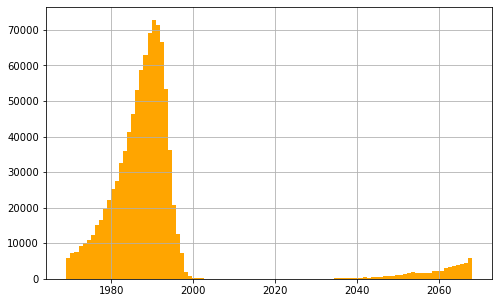

In [323]:
data.CustomerDOB.dt.year.hist(bins=100, color = "orange")

Looking into the histogram it's visible the majority of the distribution in the left block. The block to the right contains the customers' date of birth which fall around the year 2060. This happened because changing the dtype from object to datetime we collide in the millennium bag: the years in object are saved with just the last 2 numbers (for example 1950 is saved as 50), so the transformation creates problems because some dates will be saved as 1950 others in 2050. To solve this problem we subtract 100 to the years that come after the year 2005 (so after the end of the central block). Infact to open a bank account in India it's necessary to have at least 10 years, so there cannot be customers born after the year 2005.

<AxesSubplot:>

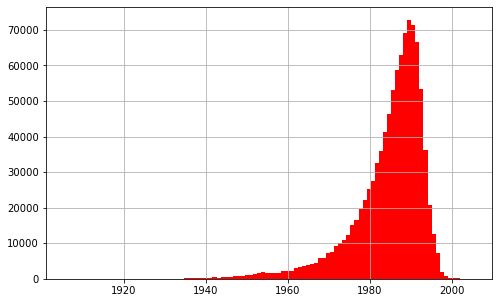

In [324]:
data.loc[data.CustomerDOB.dt.year > 2005, "CustomerDOB"] = data.loc[data.CustomerDOB.dt.year > 2005, 'CustomerDOB'] - pd.DateOffset(years = 100)
data.CustomerDOB.dt.year.hist(bins=100, color = "red")

In [325]:
data.CustomerDOB.dt.year.agg(lambda x: pd.Series.mode(x))

0    1990.0
Name: CustomerDOB, dtype: float64

Now it's visible in the histogram the right distribution of the customers' date of birth, with a peak of 72789 birthdays in 1990.

In [326]:
data.CustomerDOB.dt.year.value_counts()

1990.0    72789
1991.0    71288
1989.0    69238
1992.0    66708
1988.0    63004
          ...  
1920.0        2
1911.0        2
1916.0        2
1925.0        1
1918.0        1
Name: CustomerDOB, Length: 99, dtype: int64

#### NA values

Let's have a look if in the dataset there are some missing values or some false values that need to be drop.

In [327]:
data.isna().sum()

TransactionID                  0
CustomerID                     0
CustomerDOB                60736
CustGender                  1100
CustLocation                 151
CustAccountBalance          2369
TransactionDate                0
TransactionTime                0
TransactionAmount (INR)        0
dtype: int64

The number of values that is NA concerns 4 variables (customerDOB, custGender, custLocation, CustAccountBalance), anyway their number is very small compare to the amount of data that we own (1048567 transactions) so we delete this data.

In [328]:
data.dropna(inplace = True)

In [329]:
data.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

#### CustGender

In [330]:
data['CustGender'].value_counts()

M    712454
F    272868
Name: CustGender, dtype: int64

the Customer's gender can be Male or Female.

#### TransactionAmount (INR)

To semplify the code we change the column name of the variable "TransactionAmount (INR)" in "TransactionAmount".

In [331]:
data.rename(columns = {'TransactionAmount (INR)':'TransactionAmount'}, inplace = True)

#### Duplicated

In [332]:
data[data.duplicated()]

Empty DataFrame
Columns: [TransactionID, CustomerID, CustomerDOB, CustGender, CustLocation, CustAccountBalance, TransactionDate, TransactionTime, TransactionAmount]
Index: []

There are no duplicated data, so it's possible to say that the dataset is clean.

In [333]:
data.shape

(985322, 9)

The number of transactions now are in total 985322 with 9 variables.

## EDA: Exploratory data analysis

In [334]:
round(data.describe(),1)

CustAccountBalance  TransactionAmount
count            985322.0           985322.0
mean             106061.2             1452.4
std              817905.4             6139.8
min                   0.0                0.0
25%                4582.1              151.0
50%               16006.3              431.0
75%               53759.1             1125.0
max           115035495.1          1560035.0

#### DA FARE EDA

### 2.1.3: Feature Engineering in Clients dataset

To begin the Feature Engineering we create a new dataset where to put all the new variables created considering the clients.

In [335]:
clients = pd.DataFrame()

It's time now to create the variables:

a) Number of transactions:

In [336]:
numero_transazioni = data.groupby(['CustomerID'])["TransactionID"].count()
clients["Num_transaction"]=numero_transazioni

b) Number of transactions with a balance bigger than 100 USD (i converted the INR in USD):

In [337]:
data.loc[data.TransactionAmount*0.012 <= 100, 'Transaction>100USD'] = 0
data.loc[data.TransactionAmount*0.012 > 100, 'Transaction>100USD'] = 1
clients["Transaction>100USD"] = data.groupby('CustomerID')['Transaction>100USD'].sum()

c) Average amount of the transactions:

In [338]:
clients["Average_transaction"]= data.groupby('CustomerID')['TransactionAmount'].mean()

d) Average balance:

In [339]:
clients["Average_balance"]= data.groupby('CustomerID')['CustAccountBalance'].mean()

e) Utilisation (Average difference between the balance and the transaction amount for each customer):

In [340]:
data["difference"]= data['CustAccountBalance']-data['TransactionAmount']
clients["Utilisation"]= data.groupby('CustomerID')['difference'].mean()

f) Most common gender of the customer:

In [341]:
data.loc[data.CustGender == "M", 'GenderNum'] = 0
data.loc[data.CustGender == "F", 'GenderNum'] = 1
clients["GenderNum"]= data.groupby('CustomerID')['GenderNum'].sum()
clients.loc[clients.GenderNum > clients.Num_transaction/2, 'Gender'] = "F"
clients.loc[clients.GenderNum < clients.Num_transaction/2, 'Gender'] = "M"
clients.loc[clients.GenderNum == clients.Num_transaction/2, 'Gender'] = random.choice(["M", "F"])
clients.drop('GenderNum', inplace=True, axis=1)
data.drop('GenderNum', inplace=True, axis=1)

h) Most frequent location of the customer:

In [343]:
location = data.groupby(['CustomerID'])['CustLocation'].agg(pd.Series.mode)
lista=[]
for i in location.index:
    if type(location.loc[i]) == str:
        lista.append(location[i])
    else:
        lista.append(location[i][0])
clients["Location"]=lista

###  2.1.3: NEW FEATURES

we are going to create 20 new features, to give more details about the dataset's information:

1) Total Transactions: the sum of all the transaction for a client.

In [345]:
clients["Total_transactions"]= data.groupby('CustomerID')['TransactionAmount'].sum()

2) Max transaction: the maximum value for a client's transaction.

In [346]:
clients["Max_transaction"]= data.groupby('CustomerID')['TransactionAmount'].max()

3) Min transaction:  the minimum value for a client's transaction.

In [347]:
clients["Min_transaction"]= data.groupby('CustomerID')['TransactionAmount'].min()

4) Max balance:  the maximum value for a client's balance.

In [348]:
clients["Max_balance"]= data.groupby('CustomerID')['CustAccountBalance'].max()

5) Min balance: the minimum value for a client's balance.

In [349]:
clients["Min_balance"]= data.groupby('CustomerID')['CustAccountBalance'].min()

6) Max Utilisation: the maximum utilisation value for a client ( difference between the balance and the transaction amount).

In [350]:
clients["Max_Utilisation"]= data.groupby('CustomerID')['difference'].max()

7) Min Utilisation: the minimum utilisation value for a client ( difference between the balance and the transaction amount).

In [351]:
clients["Min_Utilisation"]= data.groupby('CustomerID')['difference'].min()

8)  Transaction > 100: Number of transaction bigger than 100 INR.

In [352]:
data.loc[data.TransactionAmount <= 100, 'Transaction>100'] = 0
data.loc[data.TransactionAmount > 100, 'Transaction>100'] = 1
clients["Transaction>100"] = data.groupby('CustomerID')['Transaction>100'].sum()

9) Balance>10000: Number of times between every transaction that the balance is bigger than 10000 INR.

In [353]:
data.loc[data.CustAccountBalance <= 10000, 'Balance>10000'] = 0
data.loc[data.CustAccountBalance > 10000, 'Balance>10000'] = 1
clients["Balance>10000"] = data.groupby('CustomerID')['Balance>10000'].sum()

10) Utilisation<1000: Number ot times that utilisation is less than 1000.

In [354]:
data.loc[data.difference < 1000, 'Utilisation>1000'] = 0
data.loc[data.difference >= 1000, 'Utilisation<1000'] = 1
clients["Utilisation<1000"] = data.groupby('CustomerID')['Utilisation<1000'].sum()

11) Percentage of transaction > 100 on the total:

In [355]:
clients["%transaction>100"] = (clients["Transaction>100"]/clients["Num_transaction"]*100).round(2)

12) Percentage of Balance > 10000 on the total:

In [356]:
clients["%Balance>10000"] = (clients["Balance>10000"]/clients["Num_transaction"]*100).round(2)

13) Percentage of Utilisation < 1000 on the total:

In [357]:
clients["%Utilisation<1000"] = (clients["Utilisation<1000"]/clients["Num_transaction"]*100).round(2)

14) Most common day for transactions:

In [358]:
data['Day'] = data.TransactionDate.dt.dayofweek
data.Day =  data.Day.astype(str)
day = data.groupby(['CustomerID'])['Day'].agg(pd.Series.mode)
lista=[]
for i in day.index:
    if type(day.loc[i]) == str:
        lista.append(day[i])
    else:
        lista.append(day[i][0])
clients["Day"] = lista

15) most common month for transactions:

In [363]:
data['Month'] = data['TransactionDate'].dt.month
data.Month =  data.Month.astype(str)
month = data.groupby(['CustomerID'])['Month'].agg(pd.Series.mode)
lista=[]
for i in month.index:
    if type(month.loc[i]) == str:
        lista.append(month[i])
    else:
        lista.append(month[i][0])
clients["Month"] = lista

16) Time of the day with more transactions:

In [368]:
data['Hour'] = data['TransactionTime'].dt.hour
data.Hour =  data.Hour.astype(str)
hour = data.groupby(['CustomerID'])['Hour'].agg(pd.Series.mode)
lista=[]
for i in hour.index:
    if type(hour.loc[i]) == str:
        lista.append(hour[i])
    else:
        lista.append(hour[i][0])
clients["Hour"] = lista

17) Time since the first and last transaction in days:

In [374]:
data["time(day)"] = pd.to_datetime('today') - data.TransactionDate
clients["dist_minimum"] = data.groupby('CustomerID')['time(day)'].min()
clients["dist_maximum"] = data.groupby('CustomerID')['time(day)'].max()
clients["Time(day)"] = clients["dist_maximum"] - clients["dist_minimum"]
clients["Time(day)"] = clients["Time(day)"].dt.days
clients.drop('dist_minimum', inplace=True, axis=1)
clients.drop('dist_maximum', inplace=True, axis=1)

18) Costumer age Max (in the year 2016, year to which the payment have been done. we are going to take the max value and so the oldest person for each bank account):

In [375]:
data['CustomerAge'] = 2016 - data.CustomerDOB.dt.year
clients["CustomerAge_max"] = data.groupby('CustomerID')['CustomerAge'].max()

19) Costumer age Min (in the year 2016, year to which the payment have been done. we are going to take the min value: the age of the youngest person of each bank account):

In [376]:
clients["CustomerAge_min"] = data.groupby('CustomerID')['CustomerAge'].min()

20) Rich Customer: Is the average_balance >10000 and the transaction been made in one of the ricchest city in India? (Mumbai, New Delhi, Delhi, )?:

In [377]:
clients.loc[(((clients.Location == "MUMBAI") | (clients.Location == "NEW DELHI") | (clients.Location == "DELHI")) & (clients["Average_balance"]>10000)), 'RichCustomer'] = "Yes"
clients.loc[((((clients.Location == "MUMBAI") | (clients.Location == "NEW DELHI") | (clients.Location == "DELHI")) & (clients["Average_balance"]<= 10000)) | ((clients.Location != "MUMBAI") & (clients.Location != "NEW DELHI") & (clients.Location != "DELHI"))), 'RichCustomer'] = "No"

In [378]:
clients.head()

Num_transaction  Transaction>100USD  Average_transaction  \
CustomerID                                                             
C1010011                  2                 0.0               2553.0   
C1010012                  1                 0.0               1499.0   
C1010014                  2                 0.0                727.5   
C1010018                  1                 0.0                 30.0   
C1010024                  1                 0.0               5000.0   

            Average_balance  Utilisation Gender   Location  \
CustomerID                                                   
C1010011          76340.635    73787.635      M  NEW DELHI   
C1010012          24204.490    22705.490      M     MUMBAI   
C1010014         100112.950    99385.450      M     MUMBAI   
C1010018            496.180      466.180      F  CHAMPARAN   
C1010024          87058.650    82058.650      M    KOLKATA   

            Total_transactions  Max_transaction  Min_transaction  ...  \
CustomerID                                                        ...   
C1010011                5106.0           4750.0            356.0  ...   
C1010012                1499.0           1499.0           1499.0  ...   
C1010014                1455.0           1205.0            250.0  ...   
C1010018                  30.0             30.0             30.0  ...   
C1010024                5000.0           5000.0           5000.0  ...   

            %transaction>100  %Balance>10000  %Utilisation<1000  Day  Month  \
CustomerID                                                                    
C1010011               100.0           100.0              100.0    0      8   
C1010012               100.0           100.0              100.0    6      8   
C1010014               100.0           100.0              100.0    0      8   
C1010018                 0.0             0.0                0.0    3      9   
C1010024               100.0           100.0              100.0    3      8   

            Hour  Time(day)  CustomerAge_max  CustomerAge_min  RichCustomer  
CustomerID                                                                   
C1010011       1         48               33               24           Yes  
C1010012      20          0               22               22           Yes  
C1010014      15          6               32               24           Yes  
C1010018      17          0               26               26            No  
C1010024      14          0               51               51            No  

[5 rows x 27 columns]

In [390]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 839081 entries, C1010011 to C9099956
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Num_transaction      839081 non-null  int64  
 1   Transaction>100USD   839081 non-null  float64
 2   Average_transaction  839081 non-null  float64
 3   Average_balance      839081 non-null  float64
 4   Utilisation          839081 non-null  float64
 5   Gender               839081 non-null  object 
 6   Location             839081 non-null  object 
 7   Total_transactions   839081 non-null  float64
 8   Max_transaction      839081 non-null  float64
 9   Min_transaction      839081 non-null  float64
 10  Max_balance          839081 non-null  float64
 11  Min_balance          839081 non-null  float64
 12  Max_Utilisation      839081 non-null  float64
 13  Min_Utilisation      839081 non-null  float64
 14  Transaction>100      839081 non-null  float64
 15  Balance>10000

#### Let's save the dataset!

In [379]:
clients.to_pickle("bank.pkl")

## 2.2 Choose your features (variables)!

Our "clients" dataset is now full of variables. There are as many as 27 of them, so it becomes very difficult to carry out analysis, create efficient visualization, and work quickly with this kind of dataset. For this reason we will carry out dimensionality reduction: we reduce our number of variables without exaggeratedly reducing the information contained in them. Before carrying out this procedure, however, we address some problems.
PCA can only be done on quantitative variables, consequently we will only consider the 21 variables that have this characteristic.

In [342]:
clients = pd.read_pickle("bank.pkl")

In [343]:
caratteristiche = ['Num_transaction', 'Transaction>100USD', 'Average_transaction',
       'Average_balance', 'Utilisation',
       'Total_transactions', 'Max_transaction', 'Min_transaction',
       'Max_balance', 'Min_balance', 'Max_Utilisation', 'Min_Utilisation',
       'Transaction>100', 'Balance>10000', 'Utilisation<1000',
       '%transaction>100', '%Balance>10000', '%Utilisation<1000', 'Time(day)', 'CustomerAge_max', 'CustomerAge_min']

In [344]:
clients_quant = clients[caratteristiche]

You can perform dimensional reduction by many different methods. The method we will apply in our case will be the Principal Component Analysis. 

This method makes it possible to merge variables that are highly correlated with each other. Doing so will result in fewer variables that still contain a lot of information. In order for the dataset to be representative, the total variance of the principal components must be greater than 70%.

Fewer principal components means easier to work with and visualize data but also means less information. A higher number of principal components, on the other hand, means more information but less efficiency in work. The "game" will then be to choose the number of principal components just above 70% total explained variability.

It is possible to use only quantitative variables in PCA. Accordingly, we will not use the variables Gender, Location, Day, Month, Hour, RichCustomer. Anyway, it will be possible to incorporate them as target variables later if they bring effective characterization into our analysis.

In order to apply PCA they must meet certain conditions: be quantitative, and we have already selected only those variables that are quantitative.

As with all analyses based on variance, single outliers can affect the results especially if they are very extreme and if the sample size is low. So we start a fast check for outliers.

In [345]:
Q1 = clients_quant.quantile(0.05)
Q3 = clients_quant.quantile(0.95)
IQR = Q3 - Q1
clients_out = clients_quant[~((clients_quant < (Q1 - 1.5 * IQR)) |(clients_quant > (Q3 + 1.5 * IQR))).any(axis=1)]
clients_out = pd.DataFrame(clients_out)
print("Dataframe with outliers:",clients_quant.shape[0], "Dataframe without outliers:", clients_out.shape[0])
print("Outliers:",clients_quant.shape[0]- clients_out.shape[0])

Dataframe with outliers: 839081 Dataframe without outliers: 794956
Outliers: 44125


We remove the 44125 outliers that are in the first 0.05 percentile and in the last 0.05 percentile. In this way we will remain with 794956 data and our PC will be more precisly.

After that, the assumptions of Pearson's linear correlation index must be met.
Since the ACP is based on the pooled variance among variables, it makes sense to include in the model only variables that are at least moderately correlated with each other.
If a variable has correlation indices very close to 0 with all other variables (generally, a correlation between -0.3 and + 0.3 is considered weak), then that variable should not be included in the ACP.
This is because forcing that variable to merge with others will result in a very high loss of information, and this is a situation that is generally preferred to be avoided.

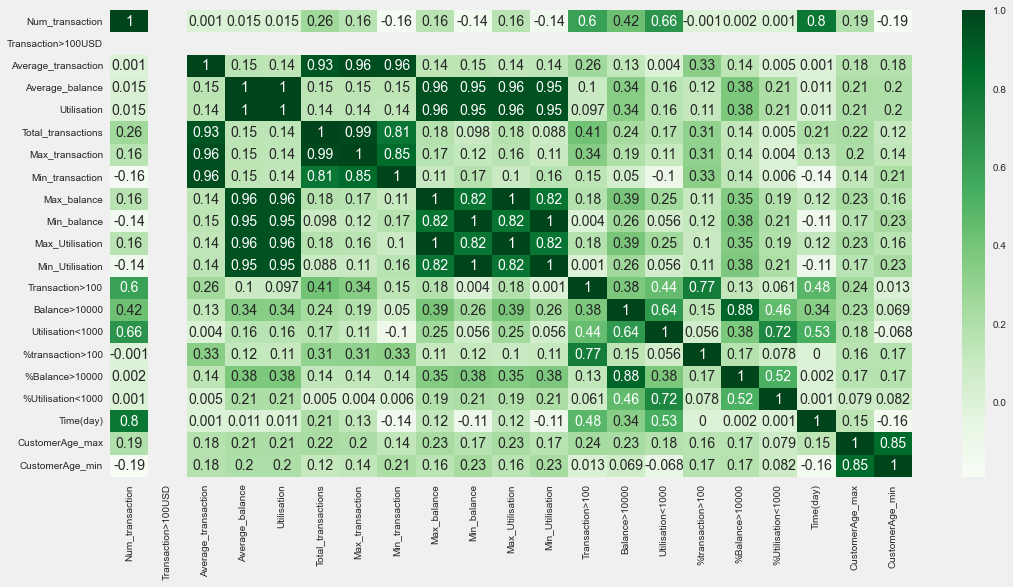

In [346]:
clients_corr = clients_out.corr()
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(18, 18))
df= df.iloc[: , [3,4,5,6,7,8,9,10,11,12,13,14,17]].copy()
plt.figure(figsize=(16,8))
sns.heatmap(round(clients_corr,3), cmap="Greens",annot=True)
plt.show()

In [347]:
caratteristiche2 = ['Num_transaction', 'Average_transaction',
       'Average_balance', 'Utilisation',
       'Total_transactions', 'Max_transaction', 'Min_transaction',
       'Max_balance', 'Min_balance', 'Max_Utilisation', 'Min_Utilisation',
       'Transaction>100', 'Balance>10000', 'Utilisation<1000',
       '%transaction>100', '%Balance>10000', '%Utilisation<1000', 'Time(day)', 'CustomerAge_max', 'CustomerAge_min']

In [348]:
clients_final = clients_out[caratteristiche2]

Transaction>100USD have no more values, so we can remove it. All the other variables are correlated with each other so we are not going to exclude any of them from the model.

High numerosity of our sample is needed, at least 10 units for each variable, and we have it. So now all the conditions are acccepted.

In [450]:
print("Number of rows:", clients_final.shape[0])
print("Number of columns:", clients_final.shape[1])

Number of rows: 794956
Number of columns: 20


### 2.2.1: STANDARDIZATION

Performing standardization is essential when you have variables of very different scales. For example, in our dataset the values of "num_transaction" and "average_transaction" or even "%transaction>100" are very different from each other. 

Standardization adjusts the values to a common scale allowing them to be compared more easily, infact purrpose of PCA is to find directions that maximizes the variance. If variance of one variable is higher than others we make the pca components biased in that direction. they will be all distributed around a mean of zero with a standard deviation of one. This allows each variable to have a similar influence on the model. Normalization doesn't solve this problem.

In [350]:
clients_stand = scaler.fit_transform(clients_final)

In [351]:
clients_stand = pd.DataFrame(clients_stand, columns = caratteristiche2)

let's start now with the principal component analysis!

### 2.2.2; 2.2.3: PCA for dimensionality reduction 

In [407]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(clients_stand)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3', 'PC4'])
principalDf

PC1       PC2       PC3       PC4
0       3.323678  5.000306  4.136805  2.067387
1      -0.138853  0.950463 -0.145977 -0.271783
2       2.256306  1.111607  3.402722  0.322776
3      -3.259487 -1.836603 -1.636101  1.712846
4       3.724301  4.906883 -3.414421 -2.067149
...          ...       ...       ...       ...
794951  1.605456 -1.108540  0.033150 -0.027328
794952  0.488501 -1.368010  0.598173  0.220145
794953 -1.993473 -0.616890  0.103797  0.663423
794954 -1.251523 -1.982719  0.551726 -0.354617
794955 -1.252667  0.398558 -0.622772 -0.228479

[794956 rows x 4 columns]

In [353]:
principalDf.to_csv(r"D:\DataScience\ADM\homework4\work\ADM-HW4-Group14\principalDf.csv", sep = "\t")

In [354]:
pca.explained_variance_ratio_

array([0.3370807 , 0.19442108, 0.15937153, 0.08937518])

In [355]:
#pca.explained_variance_ratio_
print ( "Components = ", pca.n_components_ , ";\nTotal explained variance = ",
      round(pca.explained_variance_ratio_.sum(),5)  )

Components =  4 ;
Total explained variance =  0.78025


We choose four main components for our PCA. In fact, the Total explained variance with 4 components is 75.20%, an high level of information, that allows us to reduce the dimensionality from 21 to 4.

You can see how the amount of information increases as the number of principal components increases in the following graph.

In [224]:
pca5 = PCA(n_components=5)
principalComponents5 = pca5.fit_transform(clients_stand)
principalDf5 = pd.DataFrame(data = principalComponents5
             , columns = ['PC1', 'PC2','PC3','PC4','PC5'])

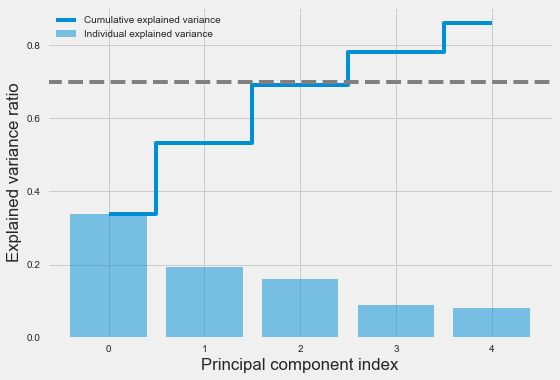

In [225]:
exp_var_pca = pca5.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.axhline(y=0.70, color='grey', linestyle='--')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

With 3 principal component, the level of total explained variance is 65,51%, which is insufficient to represent all the variability in the dataset since it is below the threshold of 70%.

Instead, choosing 5 or more principal components is not appropriate since 4 components are enough to tell the information well, and choosing 5 principal components brings an increase in information of 8,12% (and by increasing PCs the increase is vanishingly small) while moving away from our goal of dimensionality reduction.

In [228]:
clients_stand.columns

Index(['Num_transaction', 'Average_transaction', 'Average_balance',
       'Utilisation', 'Total_transactions', 'Max_transaction',
       'Min_transaction', 'Max_balance', 'Min_balance', 'Max_Utilisation',
       'Min_Utilisation', 'Transaction>100', 'Balance>10000',
       'Utilisation<1000', '%transaction>100', '%Balance>10000',
       '%Utilisation<1000', 'Time(day)', 'CustomerAge_max', 'CustomerAge_min'],
      dtype='object')

In [230]:
pca_comp = pd.DataFrame(data = pca.components_, 
                           columns = caratteristiche2, 
              index= ['PC1', 'PC2', 'PC3','PC4']) 
pca_comp.T

PC1       PC2       PC3       PC4
Num_transaction      0.070458  0.186988  0.418323  0.279434
Average_transaction  0.163953  0.376013 -0.262797  0.020855
Average_balance      0.348765 -0.190766 -0.055889  0.123100
Utilisation          0.347505 -0.195332 -0.053018  0.123073
Total_transactions   0.173646  0.407581 -0.134716  0.099625
Max_transaction      0.170174  0.398195 -0.184395  0.073296
Min_transaction      0.145294  0.324927 -0.323201 -0.034651
Max_balance          0.342120 -0.153083  0.013007  0.172856
Min_balance          0.322291 -0.212242 -0.123491  0.058172
Max_Utilisation      0.340974 -0.157151  0.015489  0.172808
Min_Utilisation      0.321013 -0.216907 -0.120477  0.058151
Transaction>100      0.134300  0.280272  0.232436  0.125750
Balance>10000        0.221434  0.078545  0.304013 -0.248165
Utilisation<1000     0.146047  0.108636  0.434809 -0.122389
%transaction>100     0.116809  0.210409 -0.029803 -0.059267
%Balance>10000       0.215730 -0.004499  0.133974 -0.412120
%Utilisation<1000    0.134948 -0.023751  0.206623 -0.419754
Time(day)            0.058962  0.165535  0.378548  0.280160
CustomerAge_max      0.145120  0.096328  0.014756 -0.316428
CustomerAge_min      0.118220  0.023613 -0.150566 -0.433166

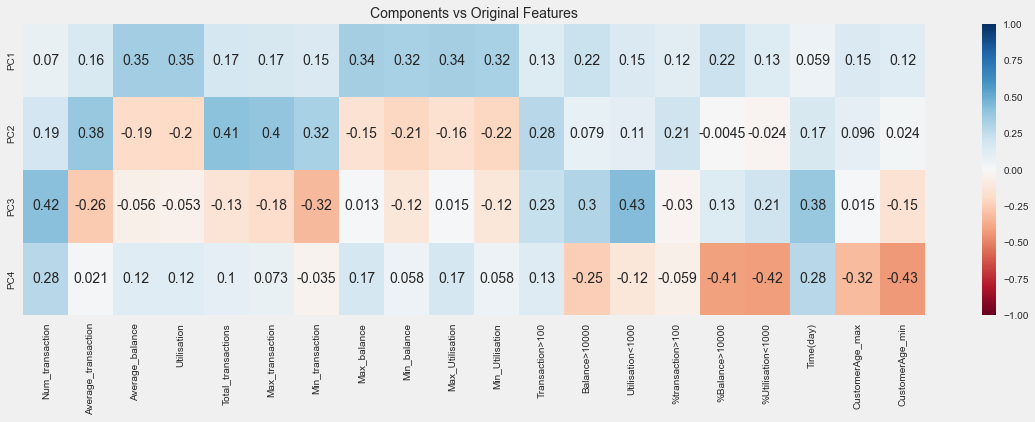

In [269]:
plt.figure(figsize=(18,5))
y_axis_labels = ["PC1", "PC2", "PC3", "PC4"]
x_axis_labels = caratteristiche2
ax = sns.heatmap(pca.components_,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True,
            xticklabels=x_axis_labels,
            yticklabels=y_axis_labels
            )
plt.title('Components vs Original Features',fontsize = 14)
plt.show()

In the table you can see how much each feature is correlated with the principal components. The closer the value is to 1 the more the variable is positively correlated with the principal component (if equal to 1 it is positively correlated perfectly), the closer the value is to -1 the more it is negatively correlated (if equal to -1 it is negatively correlated perfectly). On the other hand, if the value is close to zero then the variable is uncorrelated.


The first principal component is marked by a correlation more substantial of the balance and utilisation (average, min and max) In fact, holding the other variables stationary, increasing for example "Utilisation" by 1, the first principal component increases on average by 0.4.

The second principal component depends on average especially on variables that tell about transactios (Total, max, min, average).

the third is characterized by the "transaction>100", "utilisation<1000" and "balance >10000" with a negative correlation.

While the forth principal component is characterized by the time, costumer age and some other variables. 

Anyway the features are not strongly correlated with any of the principal components, all the values of correlation correspond to less than 0.5 (absolute value).

## 2.3: Clustering!

### 2.3.1: K-means clustering algorithm

K-means is an algorithm that divides the dataset into k nonoverlapping, independent clusters such that observations in one cluster are similar to each other and dissimilar to those in the remaining sets. The similarity between samples is used to shape the clusters, making sure that similar observations end up in the same set. The k-means then attempts to maximize the inter-cluster distance between samples and minimize the intra-cluster distance.
 
there are three popular categories of clustering algorithms: Partitional clustering, Hierarchical clustering, Density-based clustering. The K-means method is a partitional type. Thus, it is characterized by the fact that it divides data objects into non-overlapping clusters. In other words, no object can be a member of more than one cluster, and each cluster must have at least one object. These techniques require the user to specify the number of clusters.
These algorithms are nondeterministic , meaning that they could produce different results from two separate runs even if the runs were based on the same input.

Partitional clustering methods have several strengths :

1) They work well when clusters have a spherical shape.

2) They are scalable with respect to the complexity of the algorithm.

They also have several weaknesses :

1) They are not suitable for clusters with complex shapes and different sizes.

2) They break down when used with clusters of different densities.

### 2.3.2: Optimal number of clusters

The first step is to randomly select k centroids, where k is equal to the number of clusters chosen. Centroids are data points that represent the center of a cluster.
The process consists of two steps; it is called expectation-maximization . The expectation phase assigns each data point to the nearest centroid. Then, the maximization phase calculates the average of all points for each cluster and sets the new centroid.
The quality of the cluster assignments is determined by calculating the sum of squared error (SSE) after the centroids converge or match the assignment of the previous iteration. The SSE is defined as the sum of the squared Euclidean distances of each point from its nearest centroid. Since this is a measure of error, the goal of k -mean is to try to minimize this value.
After choosing a number of clusters and initial centroids, the expectation-maximization step is repeated until the centroid positions reach convergence and remain unchanged.


Some of the commonly used methods to estimate the appropriate number of clusters are the elbow method, the contour coefficient and the Intracluster distance.

#### The elbow method

In [356]:
kmeans_kwargs = {
    "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(principalDf)
    sse.append(kmeans.inertia_)

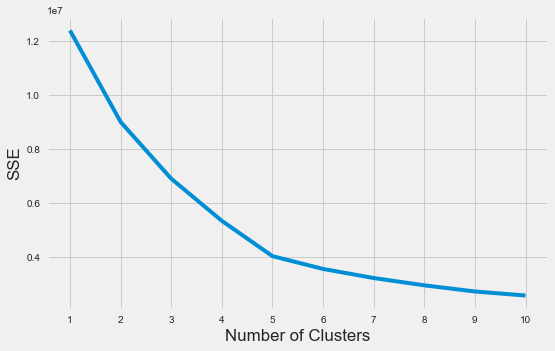

In [357]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Quando si traccia SSE in funzione del numero di cluster, si noti che SSE continua a diminuire all'aumentare di k. Man mano che vengono aggiunti più centroidi, la distanza da ciascun punto al centroide più vicino diminuirà.
C'è un punto debole in cui la curva SSE inizia a piegarsi noto come punto del gomito . Si ritiene che il valore x di questo punto sia un ragionevole compromesso tra errore e numero di cluster. k=3 

codice implementato con 3 clusters con centroidi distinti. il centro di ogni cluster rappresenta la media di tutte le osservazioni che appartengono a quel cluster.

#### Intercluster distance method

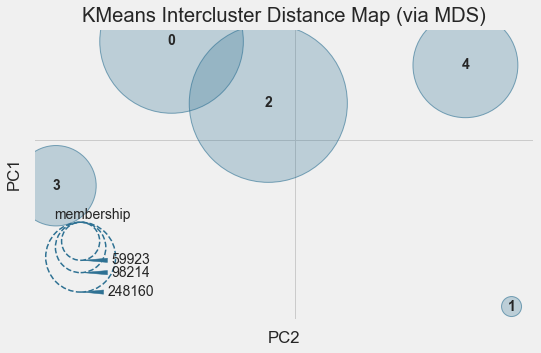

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [397]:
model = KMeans(5)
visualizer = InterclusterDistance(model)

visualizer.fit(principalDf)        # Fit the data to the visualizer
visualizer.show()

### 2.3.4: K-means

+ The function `Get_initial_centroids` for a given integer `k` returns as many samples from the dataframe `df` making sure they are not 'too close' to each other, these `k` samples will be the initial centroids of the **K-Means** procedure

In [359]:
def Get_initial_centroids(dataframe,k):
    
    # IF REPRODUCIBILITY IS NECESSARY
    np.random.seed(123)
    
    # MEMORY PRE-ALLOCATION
    initial_centroids = pd.DataFrame(np.zeros((k,4)),index=[i for i in range(1,k+1)], columns=['PC1','PC2','PC3','PC4'])

    # WE CHOOSE AS FIRST CENTROID THE AVERAGE POINT OF THE DATA
    initial_centroids.loc[1]=np.array(dataframe.mean()) 

    # LET'S SET THE REMAINS CENTROIDS
    for j in range(2,k+1):
        
        # SUPPORT VARIABLES
        candidate = pd.DataFrame(np.zeros((10,4)) ,columns=['PC1','PC2','PC3','PC4'])
        distance = pd.Series(np.zeros(10))        
        
        # FOR EACH ITERATION WE PICK TEN CANDIDATES FOR THE ROLE OF j-TH CENTROID
        for i in range(10):
            sample = np.array(dataframe.sample(n=1).iloc[0])
            candidate.iloc[i] =sample
            distance.iloc[i]=((((initial_centroids.loc[1:j-1]-sample)**2).sum(axis=1))**(1/2)).min()
        
        # AMONG THE CANDIDATES WE CHOOSE WHICH THE MINIMUM DISTANCE FROM THE VARIOUS CENTROIDS IS MAXIMUM.
        initial_centroids.loc[j]=np.array(candidate.iloc[distance.idxmax()])
    

    return initial_centroids

+ Here `K_means` is an implementation of the K-Means procedure, given the `initial_centroids` from `Get_initial_centroids`, it splits the dataframe in `n_chunk` chunks and analyzes them one by one; each point belonging to a chunck is associated with the nearest centroid, and before moving on to the next chunck the centroids are updated. This last step, however, is performed only if the distances between the possible updated centroids and the current ones exceeds a certain fixed threshold, qualitatively represented by the input parameter `tollerance`.

In [393]:
def K_means(dataframe, n_chunk, initial_centroids, tollerance ):
    
    k=initial_centroids.shape[0]
    
    centroids = initial_centroids.copy(deep=True)
    
    n_chunk_limits = np.linspace(0, dataframe.shape[0], num=(n_chunk +1), endpoint=True, dtype=int)
    
    clusters = {'Sum':centroids.to_numpy(copy=True) , 'counter': np.ones((k,1), dtype=int),'stop_update': np.ones(k)}
    
    final_cluster=pd.Series(np.zeros(len(dataframe),dtype=int))
    old_stop = np.ones(k)
    
    for i in range(n_chunk):
        
        current_chunk = dataframe.iloc[n_chunk_limits[i]:n_chunk_limits[i+1]].copy(deep=True)
        
        cluster_assignment = current_chunk.apply(lambda row: (((centroids-row)**2).sum(axis =1)**(1/2)).idxmin(), axis=1)
        
        final_cluster.iloc[n_chunk_limits[i]:n_chunk_limits[i+1]]=cluster_assignment.to_numpy(copy=True)
        
        if  (clusters['stop_update']/old_stop).max()>tollerance:
            
            for j in range(1,k+1):
                
                new_points_cluster_j =  current_chunk[cluster_assignment == j].to_numpy(copy=True)
                
                if len(new_points_cluster_j)>0:
                    clusters['Sum'][j-1]+= new_points_cluster_j.sum(axis=0) 
                    clusters['counter'][j-1]+= len(new_points_cluster_j) 
                    
            old_centroids = centroids.copy(deep=True)
            old_stop = clusters['stop_update']
            centroids = pd.DataFrame(clusters['Sum']/clusters['counter'], index=[i for i in range(1,(k+1))], columns =['PC1', 'PC2','PC3','PC4'])
            clusters['stop_update'] = np.sqrt(((centroids-old_centroids)**2).sum(axis =1))
    
    cluster_indeces=[]
    centroids_distances=[]
        
    for j in range(1,k+1):
        
        cluster_indeces.append(dataframe[final_cluster==j].index) 
        
        centroids_distances.append((((dataframe.loc[cluster_indeces[-1]]-centroids.loc[j])**2).sum(axis =1)**(1/2)).sum())
    
    SSE = sum(centroids_distances)
    
            
    return cluster_indeces, centroids, SSE     

In [394]:
initial_centroids = Get_initial_centroids(principalDf,5)

In [395]:
cluster_indeces, centroids, SSE = K_means(principalDf, 100, initial_centroids, 0.05)

In [417]:
labels = pd.Series(np.zeros(principalDf.shape[0]))
for i in range(len(cluster_indeces)):
    labels.loc[cluster_indeces[i]] = i

In [420]:
principalDf["cluster_scratch"] = labels

In [423]:
principalDf

PC1       PC2       PC3       PC4  cluster  cluster_scratch
0       3.323678  5.000306  4.136805  2.067387        0              2.0
1      -0.138853  0.950463 -0.145977 -0.271783        1              0.0
2       2.256306  1.111607  3.402722  0.322776        0              2.0
3      -3.259487 -1.836603 -1.636101  1.712846        2              3.0
4       3.724301  4.906883 -3.414421 -2.067149        3              1.0
...          ...       ...       ...       ...      ...              ...
794951  1.605456 -1.108540  0.033150 -0.027328        1              0.0
794952  0.488501 -1.368010  0.598173  0.220145        1              0.0
794953 -1.993473 -0.616890  0.103797  0.663423        2              3.0
794954 -1.251523 -1.982719  0.551726 -0.354617        1              0.0
794955 -1.252667  0.398558 -0.622772 -0.228479        2              3.0

[794956 rows x 6 columns]

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

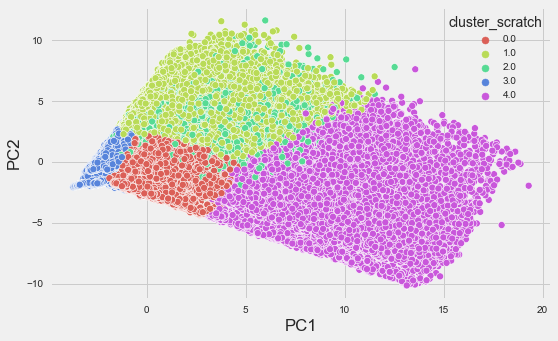

In [424]:
unique_values = len(principalDf.cluster.unique())
sns.scatterplot(x = principalDf.PC1, y = principalDf.PC2,
                palette = sns.color_palette("hls", unique_values),
                hue = principalDf.cluster_scratch)

<AxesSubplot:xlabel='PC3', ylabel='PC4'>

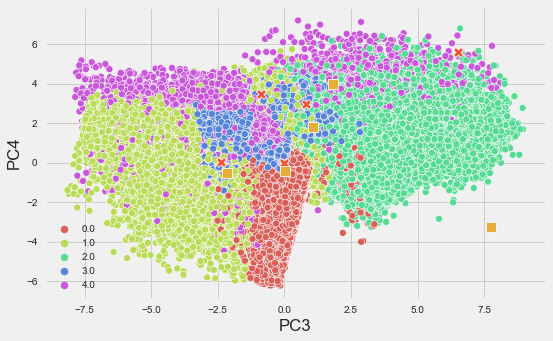

In [448]:
unique_values = len(principalDf.cluster.unique())
sns.scatterplot(x = principalDf.PC3, y = principalDf.PC4,
                palette = sns.color_palette("hls", unique_values),
                hue = principalDf.cluster_scratch)
sns.scatterplot(x = np.array(list(initial_centroids.PC1.values)),y =np.array(list(initial_centroids.PC2.values)), marker = "X", s = 100, palette = "black")

sns.scatterplot(x = np.array(list(centroids[:,0])),y = np.array(list(centroids[:,1])), marker = "s", s = 100, palette = "black")
#ax.scatter(np.array(list(centroids.PC1.values)),np.array(list(centroids.PC2.values)),marker='o',c=color[0:k],label=' final centroids')


### 2.3.4: K-means ++

In [408]:
kmeans = KMeans(init="k-means++",n_clusters=5).fit(principalDf)
centroids = kmeans.cluster_centers_
print(centroids)

[[-2.17324159 -0.53991417 -0.79010553  0.88297927]
 [ 0.01054673 -0.42896976  0.18717025 -1.03453644]
 [ 1.05736622  1.80355153  3.43755405  1.03300772]
 [ 1.82988229  3.98770355 -2.63161748 -0.18605405]
 [ 7.77389524 -3.25146306 -1.16343067  1.20673739]]


In [411]:
cluster

array([0, 1, 0, ..., 2, 1, 2])

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

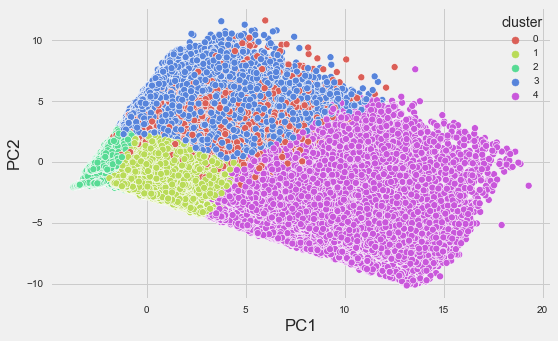

In [410]:
model = KMeans(init="k-means++", n_clusters = 5)
cluster = model.fit_predict(principalDf)
principalDf["cluster"] = cluster
unique_values = len(principalDf.cluster.unique())
sns.scatterplot(x = principalDf.PC1, y = principalDf.PC2,
                palette = sns.color_palette("hls", unique_values),
                hue = principalDf.cluster)

<AxesSubplot:xlabel='PC3', ylabel='PC4'>

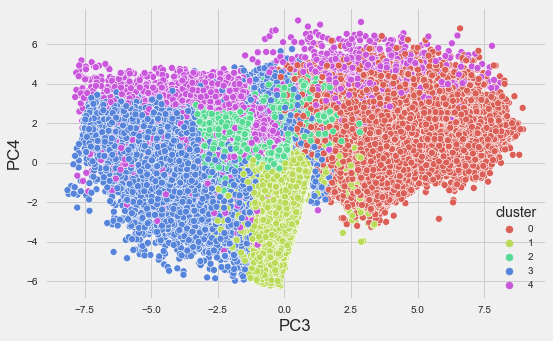

In [425]:
unique_values = len(principalDf.cluster.unique())
sns.scatterplot(x = principalDf.PC3, y = principalDf.PC4,
                palette = sns.color_palette("hls", unique_values),
                hue = principalDf.cluster)

## 2.4 Analysing your results!

### 2.4.1: Identify the cluster 

Let's take the feature that is more correlated with every PCA: we will take "Costumer Age Min", "% Transaction > 100", "Balance > 1000"

### 2.4.2: Categories

In [238]:
clients_cat = clients_final

In [282]:
clients_cat['CustomerAge_min_c'] = pd.cut(clients_final.CustomerAge_min, bins = [0,18,30,50,100], labels=['young', 'young adult', 'adult', "old"])

In [297]:
clients_cat["Utilisation<1000_c"] = pd.cut(clients_final["Utilisation<1000"], bins = [-1,0,1,2,3], labels=['0', '1', '2', "3"])

In [305]:
clients_cat["Total_transactions_c"] = pd.cut(clients_final["Total_transactions"], bins = [0,1000,2000,3000,10000000], labels=['<1000', '1000-2000', '2000-3000', "+3000"])

In [309]:
clients_cat["Max_transaction_c"] = pd.cut(clients_final["Max_transaction"], bins = [0,1000,2000,3000,10000000], labels=['<1000', '1000-2000', '2000-3000', "+3000"])

### 2.4.3: Pivot table

In [284]:
table = pd.crosstab(clients_cat['CustomerAge_min_c'], cluster, margins=True, margins_name="Total")
table

col_0                    0       1       2      3      4   Total
CustomerAge_min_new                                             
young                  162     697    1481    721     69    3130
young adult          26082  190708  193304  83782  15899  509775
adult                29129  141511   52221  13631  21316  257808
old                   4564   14445    1226     94   3914   24243
Total                59937  347361  248232  98228  41198  794956

In [307]:
table = pd.crosstab(clients_cat["Utilisation<1000_c"], cluster, margins=True, margins_name="Total")
table

col_0                   0       1       2      3      4   Total
Utilisation<1000_c                                             
0                    9972     477   97403    221      0  108073
1                   48259  345484  149986  18750  37994  600473
2                    1705    1400     843  71783   3058   78789
3                       1       0       0   7474    146    7621
Total               59937  347361  248232  98228  41198  794956

In [308]:
table = pd.crosstab(clients_cat["Total_transactions_c"], cluster, margins=True, margins_name="Total")
table

col_0                     0       1       2      3      4   Total
Total_transactions_c                                             
<1000                     0  279079  217981  40124  22812  559996
1000-2000               238   58521   24586  27337   9047  119729
2000-3000             17482    9485    5278  14193   4571   51009
+3000                 42217       7     183  16574   4739   63720
Total                 59937  347092  248028  98228  41169  794454

### 2.4.4: percentage by column for each pivot table

In [334]:
table = pd.crosstab(clients_cat['CustomerAge_min_g'], cluster ).round(2)
table.apply(lambda x: x*100/sum(x),axis = 0).round(2)

col_0                  0      1      2      3      4
CustomerAge_min_g                                   
young              16.52  23.11  42.82  49.96  11.78
young adult        16.65  20.33  24.50  26.04  15.66
adult              24.19  24.66  22.04  17.69  25.28
old                42.64  31.90  10.63   6.31  47.28

In [337]:
table = pd.crosstab(clients_cat["Utilisation<1000_c"], cluster).round(2)*100
table.apply(lambda x: x*100/sum(x),axis = 0).round(2)

col_0                   0      1      2      3      4
Utilisation<1000_c                                   
0                   16.64   0.14  39.24   0.22   0.00
1                   80.52  99.46  60.42  19.09  92.22
2                    2.84   0.40   0.34  73.08   7.42
3                    0.00   0.00   0.00   7.61   0.35

In [339]:
table = pd.crosstab(clients_cat["Total_transactions_c"], cluster).round(2)*100
table.apply(lambda x: x*100/sum(x),axis = 0).round(2)

col_0                     0      1      2      3      4
Total_transactions_c                                   
<1000                  0.00  80.40  87.89  40.85  55.41
1000-2000              0.40  16.86   9.91  27.83  21.98
2000-3000             29.17   2.73   2.13  14.45  11.10
+3000                 70.44   0.00   0.07  16.87  11.51

### 2.4.5: The results 

### 2.4.6: Clustering algorithm performance